FTEC5580 Project 2 Part 3 Logistic Regression \
Name: Man Yat Fu\
SID:1155109353

In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample 
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE,SelectFromModel
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.neural_network import MLPClassifier
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier ,ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_auc_score,roc_curve,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.figure_factory as ff
import random
random.seed(123)
from IPython.display import Image
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
filename = "UCI_Credit_Card.csv"
df = pd.read_csv(filename)
df.head()




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df = df.rename(columns={'default.payment.next.month': 'default', 
                        'PAY_0': 'PAY_1'})


In [4]:
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<h2>Data Processing

In [5]:

#Move unknown to group of "other"
edu = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[edu, 'EDUCATION'] = 4
df.EDUCATION.value_counts()


2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [6]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [7]:
# Analysis Variable & Default
def relation(Para, Para2="default"):
    result = pd.crosstab(df[Para], df[Para2])
    #Calculating the percentage of defaulters
    result['Percentage'] = round((result[result.columns[1]]/(result[result.columns[0]] + result[result.columns[1]])) * 100,2)
    print(result)
    print("")
    
relation("EDUCATION") #We can see large different betwwen education 4 to 1,2,3
relation("SEX") #Percentage is close to each other.
relation("AGE") #Percentage look like a normal distribution
relation("MARRIAGE") #Percentage is close to each other.
# relation("PAY_1")
# relation("PAY_2")
# relation("PAY_3")
# relation("PAY_4")
# relation("PAY_5")
# relation("PAY_6")



default        0     1  Percentage
EDUCATION                         
1           8549  2036       19.23
2          10700  3330       23.73
3           3680  1237       25.16
4            435    33        7.05

default      0     1  Percentage
SEX                             
1         9015  2873       24.17
2        14349  3763       20.78

default     0    1  Percentage
AGE                           
21         53   14       20.90
22        391  169       30.18
23        684  247       26.53
24        827  300       26.62
25        884  302       25.46
26       1003  253       20.14
27       1164  313       21.19
28       1123  286       20.30
29       1292  313       19.50
30       1121  274       19.64
31        988  229       18.82
32        933  225       19.43
33        931  215       18.76
34        931  231       19.88
35        887  226       20.31
36        854  254       22.92
37        812  229       22.00
38        750  194       20.55
39        755  199       20.86
40   

In [8]:
pay_s = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

df[['SEX','MARRIAGE','EDUCATION']] = df[['SEX','MARRIAGE','EDUCATION']].astype('object')
df = pd.get_dummies(df)

X = df.drop(['default','ID'], axis=1)  
y = df['default']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=32)
df_train = x_train.join(y_train)

df_majority = df_train[df_train.default == 0]
df_minority = df_train[df_train.default == 1]


print("Majority")
print(df_majority.default.count())
print("Minority")
print(df_minority.default.count())
print("Summary")
print(df_train.default.value_counts())


Majority
17523
Minority
4977
Summary
0    17523
1     4977
Name: default, dtype: int64


In [9]:
df_minority_upsampled = resample(df_minority,replace=True,n_samples = 17523,random_state= 32)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.default.value_counts()


0    17523
1    17523
Name: default, dtype: int64

In [10]:
sm = SMOTE(random_state=32)
x_SMOTE, y_SMOTE = sm.fit_resample(x_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

35046
17523


In [11]:
df_majority_downsampled = resample(df_majority,replace=False, n_samples=4977,random_state=32)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.default.value_counts()

0    4977
1    4977
Name: default, dtype: int64

<h2>LogisticRegression Model

In [12]:
def model_eval(algo, xtrain,ytrain,Xtest,ytest):
    from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,classification_report

    algo.fit(xtrain,ytrain)
    y_pred = algo.predict(xtrain)
    y_train_prob = algo.predict_proba(xtrain)[:,1]

    print('Overall Train Accuracy',accuracy_score(ytrain,y_pred))
    print('Train AUC Score',roc_auc_score(ytrain,y_train_prob))

    y_test_pred = algo.predict(Xtest)
    y_test_prob = algo.predict_proba(Xtest)[:,1]

    print('Overall Test Accuracy',accuracy_score(ytest,y_test_pred))
    print('Test AUC Score',roc_auc_score(ytest,y_test_prob))
    print('Classification Report of Test\n',  classification_report(ytest, y_test_pred))
    
    
    kf = KFold(n_splits = 5,shuffle = True,random_state = 42)
    score=[]
    for train_idx,test_idx in kf.split(xtrain,ytrain):
        xtrain_k,xtest_k = xtrain.iloc[train_idx,:],xtrain.iloc[test_idx,:]
        ytrain_k,ytest_k = ytrain.iloc[train_idx],ytrain.iloc[test_idx]
        algo.fit(xtrain_k,ytrain_k)
        y_pred_k = algo.predict(xtest_k)
        roc = roc_auc_score(ytest_k,y_pred_k)
        score.append(roc)
    print('K-Fold scores: %0.03f (+/- %0.5f)' % (np.mean(score),np.var(score,ddof=1)))
    
    f,ax =  plt.subplots(1,2,figsize=(14,6))
    ConfMatrix = confusion_matrix(ytest,y_test_pred)
    sns.heatmap(ConfMatrix,annot=True, cmap='YlGnBu', fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'],linewidths=.5,ax = ax[0])
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_title('Confusion Matrix')

    global fpr,tpr,thresholds
    fpr,tpr,thresholds = roc_curve(ytest,y_test_prob)
    ax[1].plot(fpr,tpr,color = 'r')
    ax[1].plot(fpr,fpr,color = 'green')
    ax[1].set_ylabel('TPR')
    ax[1].set_xlabel('FPR')
    ax[1].set_title('ROC Curve')
    plt.show()

In [13]:
xtrain_data = [x_train,df_upsampled.drop('default',axis = 1),df_downsampled.drop('default',axis = 1),x_SMOTE]
ytrain_data = [y_train,df_upsampled['default'],df_downsampled['default'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    global best_log
    print('Data is ',k)
    best_log = []

    param_grid = {'C': np.logspace(-5, 8, 15)}

    logreg = LogisticRegression()

    logreg_cv = RandomizedSearchCV(logreg, param_grid ,scoring = 'roc_auc', cv=5, random_state=0)

    logreg_cv.fit(i,j)
    best_log.append(logreg_cv.best_params_)

    print("Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
  

Data is  Normal Sampling
Logistic Regression Parameters: {'C': 3.727593720314938}
Data is  Over Sampling
Logistic Regression Parameters: {'C': 8.483428982440725e-05}
Data is  Under Sampling
Logistic Regression Parameters: {'C': 3.727593720314938}
Data is  SMOTE
Logistic Regression Parameters: {'C': 0.05179474679231213}


In [14]:
param_log =[{'C': 3.727593720314938},{'C': 8.483428982440725e-05},{'C': 3.727593720314938},{'C': 0.05179474679231213}]

Data is  Normal Sampling  And with hyper parameter  {'C': 3.727593720314938}
Overall Train Accuracy 0.7778222222222222
Train AUC Score 0.6529220799286832
Overall Test Accuracy 0.7786666666666666
Test AUC Score 0.6586080768659615
Classification Report of Test
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      5841
           1       0.46      0.00      0.01      1659

    accuracy                           0.78      7500
   macro avg       0.62      0.50      0.44      7500
weighted avg       0.71      0.78      0.68      7500

K-Fold scores: 0.500 (+/- 0.00000)


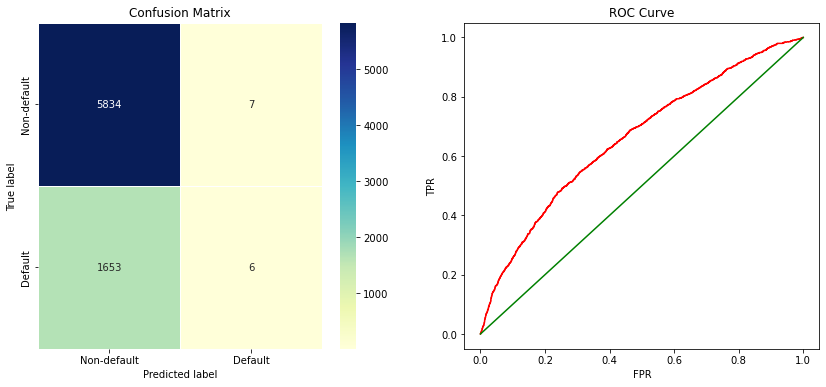

Data is  Over Sampling  And with hyper parameter  {'C': 8.483428982440725e-05}
Overall Train Accuracy 0.613422359185071
Train AUC Score 0.6470028829866796
Overall Test Accuracy 0.6252
Test AUC Score 0.6409029042584073
Classification Report of Test
               precision    recall  f1-score   support

           0       0.85      0.63      0.72      5841
           1       0.32      0.59      0.41      1659

    accuracy                           0.63      7500
   macro avg       0.58      0.61      0.57      7500
weighted avg       0.73      0.63      0.66      7500

K-Fold scores: 0.602 (+/- 0.00013)


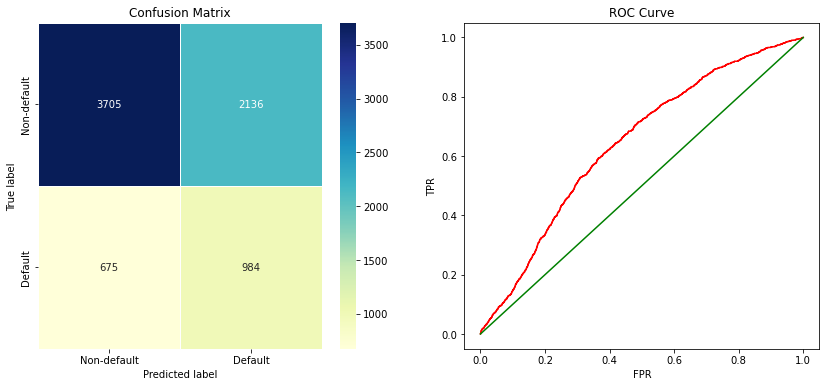

Data is  Under Sampling  And with hyper parameter  {'C': 3.727593720314938}
Overall Train Accuracy 0.6174402250351617
Train AUC Score 0.6524734090257014
Overall Test Accuracy 0.602
Test AUC Score 0.6471747955335169
Classification Report of Test
               precision    recall  f1-score   support

           0       0.86      0.59      0.70      5841
           1       0.31      0.65      0.42      1659

    accuracy                           0.60      7500
   macro avg       0.58      0.62      0.56      7500
weighted avg       0.73      0.60      0.64      7500

K-Fold scores: 0.611 (+/- 0.00016)


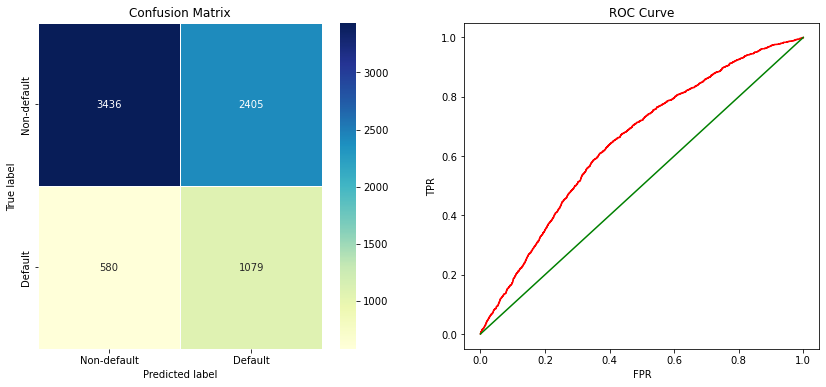

Data is  SMOTE  And with hyper parameter  {'C': 0.05179474679231213}
Overall Train Accuracy 0.5785253666609599
Train AUC Score 0.6522665449219122
Overall Test Accuracy 0.6804
Test AUC Score 0.6309172682268585
Classification Report of Test
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      5841
           1       0.31      0.37      0.34      1659

    accuracy                           0.68      7500
   macro avg       0.56      0.57      0.56      7500
weighted avg       0.70      0.68      0.69      7500

K-Fold scores: 0.589 (+/- 0.00016)


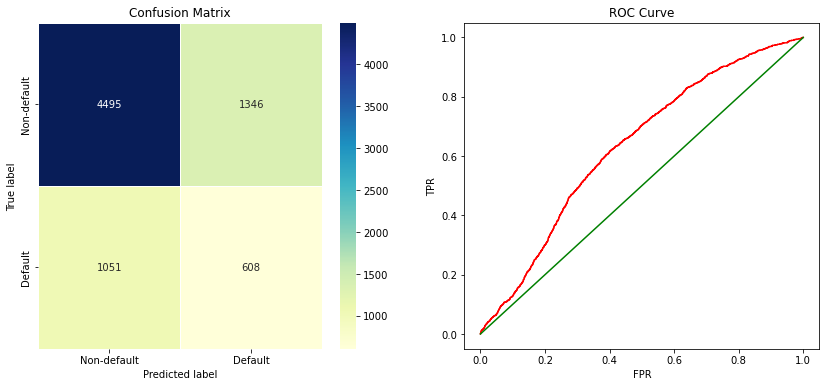

In [15]:
xtrain_data = [x_train,df_upsampled.drop('default',axis = 1),df_downsampled.drop('default',axis = 1),x_SMOTE]
ytrain_data = [y_train,df_upsampled['default'],df_downsampled['default'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']
index = [0,1,2,3]

for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_log[l])
    model_eval(LogisticRegression(**param_log[l],random_state= 42), i,j,x_test,y_test)
